In [4]:
# REPORT CORE VARIABLES
import pandas as pd
import numpy as np

# Covid-19 CSV data source
cv19_csv_source_global = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
cv19_csv_source_us = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'

#Population CSV data source
pop_csv_source_global = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\population-2019.csv'
pop_csv_source_us = r''

# General Pandas settings
pd.options.display.max_rows = 500
pd.options.display.max_columns =500


In [96]:
# STANDARD REPORT SETTINGS

# Countries of interest
countries = ['France','Germany','Italy','Spain','Sweden','UK','US','New York', 'Belgium']

# Starting date for charts etc.
start_date = pd.Timestamp(2020,3,1)

# Population to adjust all numbers to
rebase_population = 50E6

# Excel output file
excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output.xlsx'

# Folder to dump plot images to
plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'

# Columns to rename in CV19 CSV file
cdf_rename_columns = {'Province/State': 'State', 'Country/Region': 'Country'}

# Optional prefix before plot charts
plot_prefix = ""

# Whether to output files
output_files = True

In [99]:
# US REPORT SETTINGS

countries = ['New York','Texas','California','Florida','Kansas','Nebraska','UK']
start_date = pd.Timestamp(2020,3,14)
rebase_population = 50E6
excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-us.xlsx'
plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
plot_prefix = "us-"
output_files = True

In [33]:
# GLOBAL MIX REPORT SETTINGS

countries = ['Italy','Japan','UK','New York','US','Iran']
start_date = pd.Timestamp(2020,3,14)
rebase_population = 50E6
excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-all.xlsx'
plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
plot_prefix = "all-"
output_files = False

In [102]:
# SCANDI MIX REPORT SETTINGS

countries = ['UK','Sweden','Norway','Denmark','Finland','Netherlands']
# removed Iceland - small population leads to negative reporting
start_date = pd.Timestamp(2020,3,14)
rebase_population = 50E6
excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-scandi.xlsx'
plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
plot_prefix = "scandi-"
output_files = True

In [237]:
# EVERYTHING REPORT SETTINGS

countries = []
start_date = pd.Timestamp(2020,3,14)
rebase_population = 50E6
excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-gl.xlsx'
plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
plot_prefix = "gl-"
output_files = False

In [87]:
# FUNCTIONS

def load_global_cv19_dataframe():
    # LOAD & PROCESS COVID-19
    cdf = pd.read_csv(cv19_csv_source_global)

    # Rename CV19 columns with illegal characters to something safe
    cdf.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)

    # Rename long country names
    cdf = cdf.replace({'United Kingdom':'UK'})

    # keep only the State=NaN rows to make Country unique
    cdf = cdf[cdf['State'].isin([np.nan])]

    # Drop unnecesary columns
    cdf = cdf.drop(['State','Lat','Long'], axis='columns')
    
    # Group by state (ensure no duplicates)
    cdf = cdf.groupby('Country').sum()
   
    return cdf

def load_us_cv19_dataframe():
    cdf = pd.read_csv(cv19_csv_source_us)
    cdf.rename(columns={'Province_State': 'State', 'Country_Region': 'Country'}, inplace=True)

    # Rename ambiguous state names
    cdf = cdf.replace({'Georgia':'Georgia(US)'})
    
    # Drop "Unassigned" - these create negative deaths => zombie apocalypse
    cdf = cdf[cdf.Admin2 != "Unassigned"]

    # Drop unnecesary columns
    cdf = cdf.drop(['UID','iso2','iso3','FIPS','Admin2','code3','Lat','Long_','Population'], axis='columns')

    # Group by state (ensure no duplicates)
    cdf = cdf.groupby('State').sum()
    
    # Rename State as Country so stacks properly
    cdf = cdf.rename_axis(index='Country')

    # Messy - Diamond Princess appears in both global and US lists
    cdf = cdf.drop(['Diamond Princess'], axis=0)

    return cdf

def load_global_pop_dataframe():
    pdf = pd.read_csv(pop_csv_source_global)

    # Rename country names in population to allow later join
    pdf = pdf.replace({'United States of America':'US', 'United Kingdom':'UK'})

    # Rename columns for consistency with CV19 data
    pdf = pdf.rename(columns={'Location':'Country'})

    # Only keep relevant columns
    pdf = pdf[['Country','PopTotal']]

    # Group by country (ensure no duplicates)
    pdf = pdf.groupby('Country').sum()

    # Convert populations to correct numbers (source is in 1000's)
    pdf[['PopTotal']] = pdf[['PopTotal']] * 1000

    return pdf

def load_us_pop_dataframe():
    # Basic US data is in the CV19 data file
    pdf = pd.read_csv(cv19_csv_source_us)

    # Rename columns to make consistent
    pdf.rename(columns={'Province_State': 'State', 'Country_Region': 'Country', 'Population':'PopTotal'}, inplace=True)

    # Rename ambiguous state names
    pdf = pdf.replace({'Georgia':'Georgia(US)'})

    # Only keep relevant columns
    pdf = pdf[['State','PopTotal']]

    # Group by state (ensure no duplicates)
    pdf = pdf.groupby('State').sum()
    
    # Rename State as Country so stacks properly
    pdf = pdf.rename_axis(index='Country')

    # Messy - Diamond Princess appears in both global and US lists
    pdf = pdf.drop(['Diamond Princess', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Puerto Rico'], axis=0)

    return pdf

def list_countries():
    cdf = load_global_cv19_dataframe()
    cdf = cdf.append(load_us_cv19_dataframe(), sort=True, verify_integrity=True)
    return pd.DataFrame(cdf.index)

In [103]:
# CORE DATA PROCESSING
cdf = load_global_cv19_dataframe()
cdf = cdf.append(load_us_cv19_dataframe(), sort=True, verify_integrity=True)

# Filter to countries of interest
if countries != []:
    cdf = cdf.loc[countries]

# Transpose to time series
cdf = cdf.T

# Rename column axis
cdf = cdf.rename_axis(index='Country')

# Rename row axis
cdf = cdf.rename_axis(index='Date', axis=1)

# Convert index strings into dates
cdf = cdf.set_index(pd.to_datetime(cdf.index, format='%m/%d/%y'))

# Ensure in proper date order
cdf = cdf.sort_index()

# Drop all rows before start date
cdf = cdf[cdf.index >= start_date]

print('Covid-19 data imported & normalized')

# LOAD & PROCESS POPULATION DATA
pdf = load_global_pop_dataframe()
pdf = pdf.append(load_us_pop_dataframe(), sort=True, verify_integrity=True)

# Filter to countries of interest
if countries != []:
    pdf = pdf.loc[countries]

# Calculate population multiplier column (factor to normalise into standard population)
pdf[['PopMultiplier']] = 1/(pdf[['PopTotal']]/rebase_population)

print('Population data imported & normalized')

# DATA CHECKS

# Check 1:1 mapping between data sets (note different axes)
assert cdf.columns.size == pdf.index.size, 'Data-sets have different country sets - maybe country name mismatch? covid_data:{}, pop_data:{}'.format(cdf.columns.size, pdf.index.size)
print('Data checks pass')

# CALCULATE
# Generate the output data frames for all charts

# Absolute and pop adjusted total deaths
cdf_abssum = cdf
cdf_adjsum = cdf_abssum.multiply(pdf['PopMultiplier'])

# Absolute and pop adjusted daily adjusted deaths
cdf_absdaily = cdf_abssum.diff()
cdf_adjdaily = cdf_absdaily.multiply(pdf['PopMultiplier'])
cdf_adjdaily_mavg = cdf_adjdaily.rolling(window=5).mean()
print('Calculated dataframes ready')

# EXPORT
# Dump to a single Excel sheet with multiple worksheets

if output_files is True:
    with pd.ExcelWriter(excel_output_file, date_format='YYYY-MM-DD') as xl:
            cdf_abssum.to_excel(xl, sheet_name='Abs Sum Deaths')
            cdf_adjsum.to_excel(xl, sheet_name='Adj Sum Deaths')
            cdf_absdaily.to_excel(xl, sheet_name='Abs Daily Deaths')
            cdf_adjdaily.to_excel(xl, sheet_name='Adj Daily Deaths')
            cdf_adjdaily_mavg.to_excel(xl, sheet_name='Adj Daily Deaths (mavg)')

    print('Excel output file written : {}'.format(excel_output_file))
else:
    print('Excel output disabled')

Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Excel output file written : C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-scandi.xlsx


cdf_abssum -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-cumulative-deaths.png
cdf_adjsum -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-cumulative-deaths.png
cdf_absdaily -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-absolute-daily-deaths.png
cdf_adjdaily -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-daily-deaths.png
cdf_adjdaily_mavg -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-daily-deaths-mavg5.png


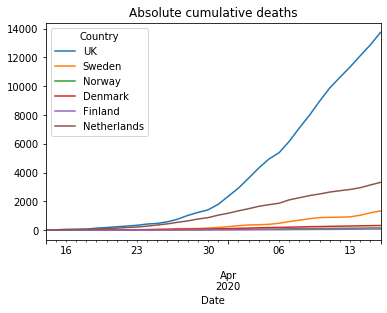

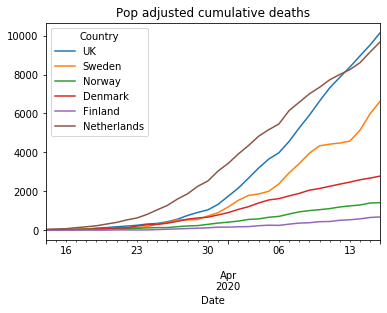

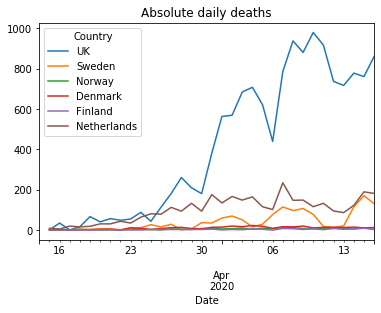

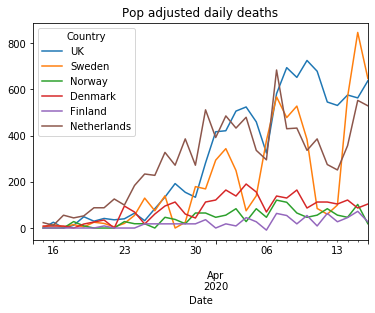

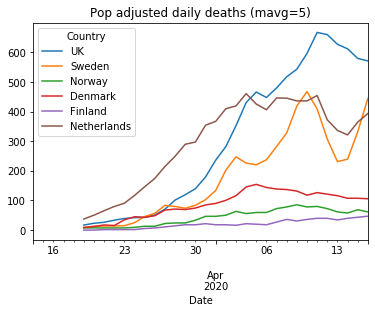

In [104]:
# PLOT & SAVE THE CHARTS

import matplotlib.pyplot as plt
import os

# plots to produce key is dataframe variable name, value is (filename, title)
export_plots = {
    'cdf_abssum':('cumulative-deaths.png','Absolute cumulative deaths'),
    'cdf_adjsum':('pop-adjusted-cumulative-deaths.png','Pop adjusted cumulative deaths'),
    'cdf_absdaily':('absolute-daily-deaths.png','Absolute daily deaths'),
    'cdf_adjdaily':('pop-adjusted-daily-deaths.png','Pop adjusted daily deaths'),
    'cdf_adjdaily_mavg':('pop-adjusted-daily-deaths-mavg5.png','Pop adjusted daily deaths (mavg=5)')}

# print plot and dump to file for each of the above
for k, (filename, title) in export_plots.items():
    df = locals()[k]
    filepath = os.path.join(plot_export_folder, plot_prefix + filename)
    df.plot(title=title)
    if output_files is True:
        plt.savefig(filepath)
        print('{} -> {}'.format(k, filepath))

if output_files is False:
    print('File output disabled')

In [17]:
# COPY DATA TO PUBLIC FOLDER
import shutil

public_folder = r'C:\Users\Jon Sturley\OneDrive\Public\covid-19'

# Copy Excel output data to public folder
try:
    shutil.copy(excel_output_file, public_folder)
except PermissionError as e:
    print('Permission denied - data file may be open in Excel')

# Copy charts to public folder
for k, (filename, title) in export_plots.items():
    filepath = os.path.join(plot_export_folder, plot_prefix + filename)
    shutil.copy(filepath, public_folder)

Todo:
    - Improve chart quality
        - Consistent colors
        - Grid lines
        - Larger
    - Set up static web site on AWS S3
    - Add function to upload to S3 bucket
    - Schedule job to run Python every day on AWS